В данном рещении попробуем воспользоваться логистической регрессией.

In this solution i use standard logistic regression.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from scipy.stats import probplot, mannwhitneyu, boxcox, shapiro


%matplotlib inline

In [2]:
def plot_qq(data,feature):
    """
    QQ-plot
    """
    sns.set(rc={"figure.figsize": (10, 6)})
    probplot(data[feature].sample(1000), plot=plt)
    plt.title(f'Q-Q plot {feature}')
    plt.show()
    
    
def plot_kde_qq_interval(data, feature):
    """
    Makes 3 plots:
    1.Builds density graph for feature in the context of target variable.
    2.QQ-plot
    3.Confidence intervals in context of target variable
    
    """
    
    sns.set(rc={"figure.figsize": (18, 12)})
    
    plt.subplot(221)
    sns.kdeplot(data[data['choose'] == 1][feature],label='Репетитор подходит', color='green')
    sns.kdeplot(data[data['choose'] == 0][feature],label='Репетитор не подходит', color='red')
    plt.xlabel(feature)
    plt.ylabel('Distribution density')
    plt.title(f'Distribution {feature} in context of target variable')
    
    plt.subplot(222)
    probplot(data[feature].sample(1000), dist='norm', plot=plt)
    plt.title(f'Q-Q plot {feature}')
    
 
    plt.show()
    
    
"""
                ТЕСТЫ
"""    
def shapiro_samples(data, feature, samples_num, bxc = False , lmbda = None):
    """
    Checking distribution for normality by the Shapiro-Wilk criterion and reverse Box-Cox conversion
    
    """
    shapiro_l = []
    boxcox_l = []
    for i in range(samples_num):
        spl = data[feature].sample(1000)
        c,p = shapiro(spl)
        shapiro_l.append(p)
        
        if bxc:
            x, y = boxcox(spl, lmbda=lmbda)
            c, p = shapiro(x)
            boxcox_l.append(p)
    
    if bxc:
        print(f'Shapiro average P-value with reverse transformation: {sum(boxcox_l)/len(boxcox_l)}')
        print(f'Shapiro average P-value without reverse transformation: {sum(shapiro_l)/len(shapiro_l)}')
        print('Threshold α = 0,05')
    if not bxc:
        print(f'Shapiro average P-value: {sum(shapiro_l)/len(shapiro_l)}')
        print('Threshold α = 0,05')
        
        
def manna_uitny(data, feature, samples_num):
    """
    Mann–Whitney average P-value
    """

    m_list = []
    for i in range(samples_num):
        spl_0 = data[data['choose']==0][feature].sample(1000)
        spl_1 = data[data['choose']==1][feature].sample(1000)
        
        c,p = mannwhitneyu(spl_0, spl_1)
        m_list.append(p)
        
    print(f'Mann–Whitney average P-value: {sum(m_list)/len(m_list)}')
    print('Threshold α = 0,05')
    
    
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    """
    Makes 3 plots:
        1. F1 score, precision, recall
        2. Histogram of probability distribution for each class
        3. Scoring table
    """
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()


In [3]:
train = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

Big imbalance in target variable

In [4]:
train['choose'].value_counts()

0    8891
1    1109
Name: choose, dtype: int64

In [5]:
train.info(), test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   10000 non-null  int64  
 1   age                  10000 non-null  float64
 2   years_of_experience  10000 non-null  float64
 3   lesson_price         10000 non-null  float64
 4   qualification        10000 non-null  float64
 5   physics              10000 non-null  float64
 6   chemistry            10000 non-null  float64
 7   biology              10000 non-null  float64
 8   english              10000 non-null  float64
 9   geography            10000 non-null  float64
 10  history              10000 non-null  float64
 11  mean_exam_points     10000 non-null  float64
 12  choose               10000 non-null  int64  
dtypes: float64(11), int64(2)
memory usage: 1015.8 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns 

(None, None)

In [6]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,10000.0,4999.5000,2886.895680,0.0,2499.75,4999.5,7499.25,9999.0
age,10000.0,45.8009,8.030274,23.0,40.00,46.0,51.00,68.0
years_of_experience,10000.0,1.9748,1.766883,0.0,0.00,2.0,3.00,9.0
lesson_price,10000.0,1702.4400,523.789062,200.0,1300.00,1550.0,2150.00,3950.0
qualification,10000.0,1.7243,0.798845,1.0,1.00,2.0,2.00,4.0
physics,10000.0,0.3706,0.482990,0.0,0.00,0.0,1.00,1.0
chemistry,10000.0,0.1215,0.326724,0.0,0.00,0.0,0.00,1.0
biology,10000.0,0.1172,0.321675,0.0,0.00,0.0,0.00,1.0
english,10000.0,0.0591,0.235824,0.0,0.00,0.0,0.00,1.0
geography,10000.0,0.0277,0.164120,0.0,0.00,0.0,0.00,1.0


### Посмотрим на распределение / Let's look at distribution

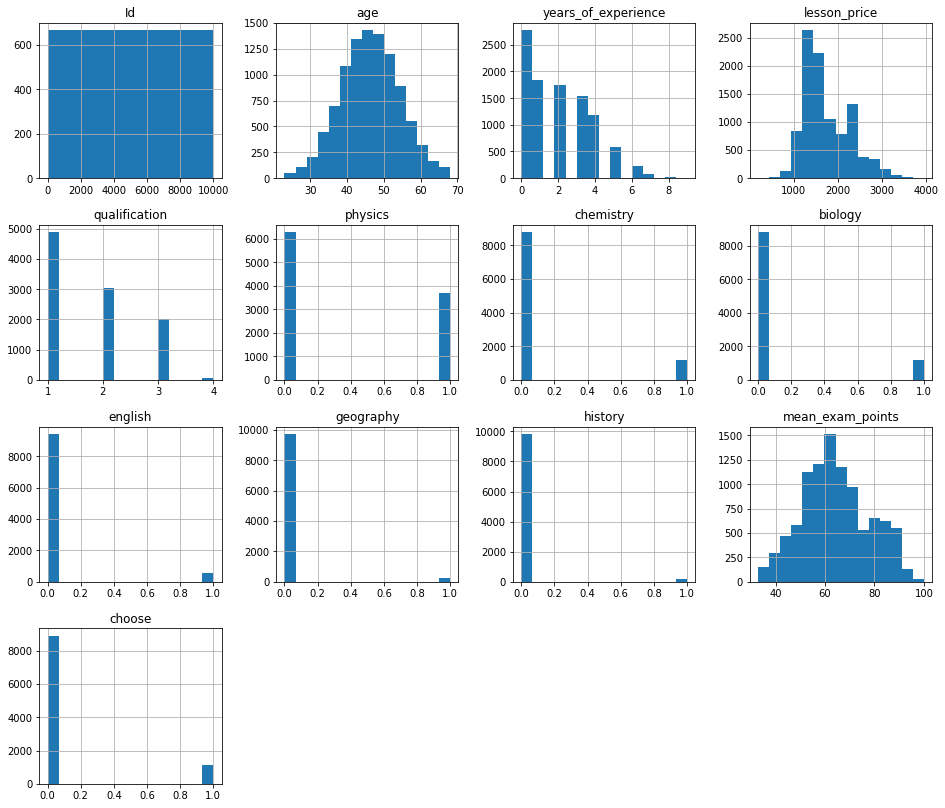

In [7]:
train.hist(figsize =(16,14),bins = 15, grid = True)
plt.show()

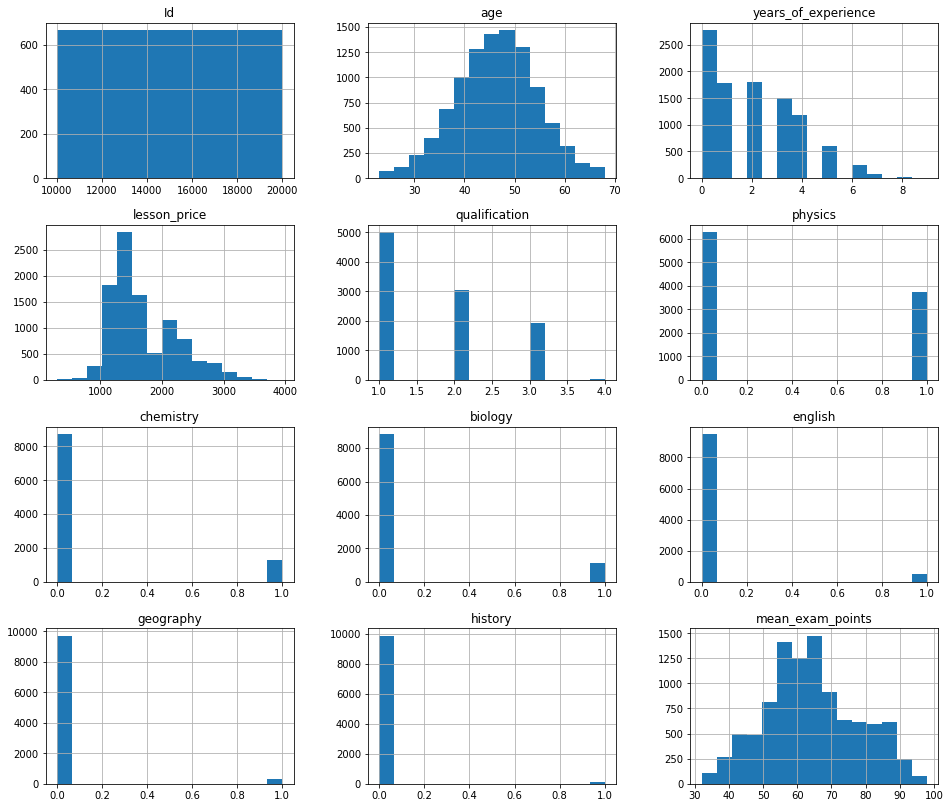

In [8]:
test_df.hist(figsize =(16,14),bins = 15, grid = True)
plt.show()

### Уделим отдельное внимание числовым признакам / Let's make special attention to numerical features
### Age

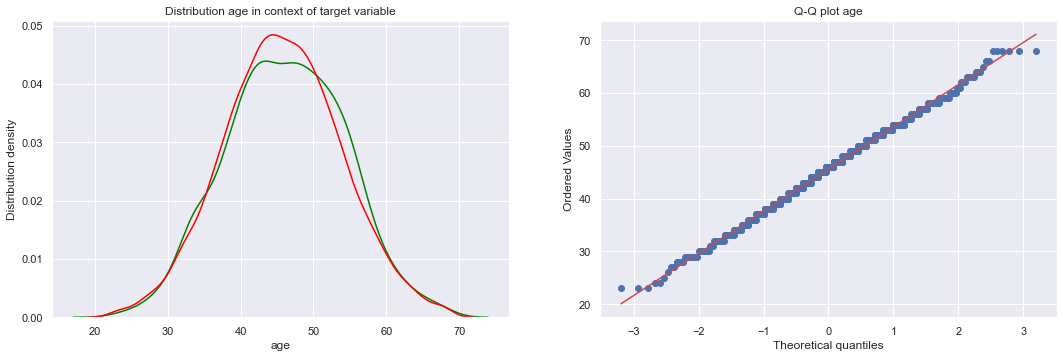

In [9]:
plot_kde_qq_interval(train, 'age')

Проверим на "нормальность"(Гауссово) по тесту Шапиро-Уилка с доверительной вероятностью 95%

Check for "normality" (Gaussian) by the Shapiro-Wilk test

In [10]:
shapiro_samples(train, 'age', 30)

Shapiro average P-value: 0.031065976716733227
Threshold α = 0,05


Распределение не дотягивает до нормального, попробуем преобразование Бокса-Кокса 

Let's try the Box-Cox transformation

In [11]:
shapiro_samples(train, 'age', 30, bxc = True)

Shapiro average P-value with reverse transformation: 0.057525049258644385
Shapiro average P-value without reverse transformation: 0.042631845149056366
Threshold α = 0,05


Let's look at Q-Q plots

In [12]:
train['age'], _ = boxcox(train['age'])
test_df['age'], _ = boxcox(test_df['age'])

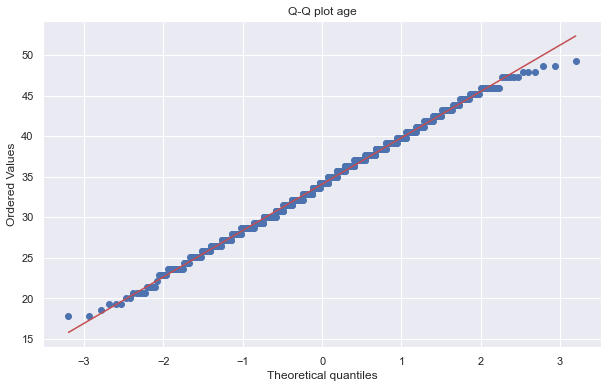

In [13]:
plot_qq(train,'age')

In [14]:
shapiro_samples(train, 'age', 30)

Shapiro average P-value: 0.035803323790120585
Threshold α = 0,05


We did not get a normal distribution, so let's use nonparametric criteria

In [15]:
manna_uitny(train, 'age', 30)

Mann–Whitney average P-value: 0.13041975012710108
Threshold α = 0,05


p > alpha - distributions are not very different / распределения не сильно различаются

### Lesson_price 

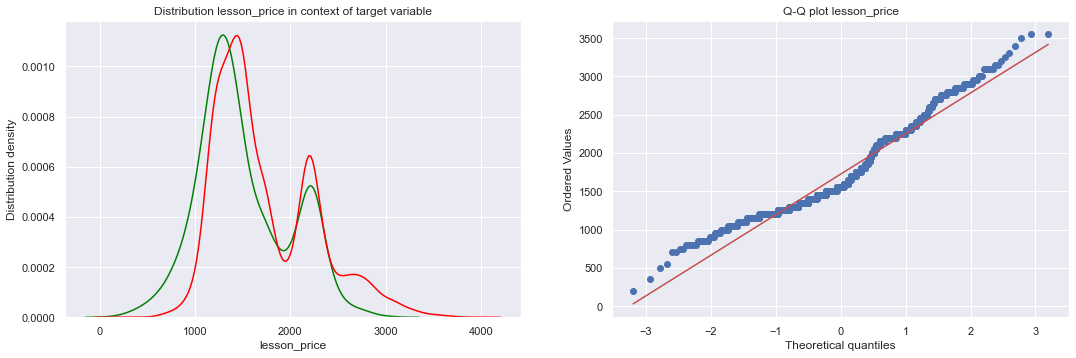

In [16]:
plot_kde_qq_interval(train, 'lesson_price')

In [17]:
shapiro_samples(train, 'lesson_price', 30, bxc = True)

Shapiro average P-value with reverse transformation: 4.089028078497702e-11
Shapiro average P-value without reverse transformation: 7.062609421272265e-20
Threshold α = 0,05


In [18]:
manna_uitny(train, 'lesson_price', 30)

Mann–Whitney average P-value: 2.4475878244892066e-15
Threshold α = 0,05


P-value сильно меньше alpha, что говорит о большой разнице в распределении двух выборок. Можно заключить, что данный признак довольно полезен.

P-value is much smaller than alpha, which indicates a large difference in distribution of two samples(for our alpha).

### Mean_exam_points 	

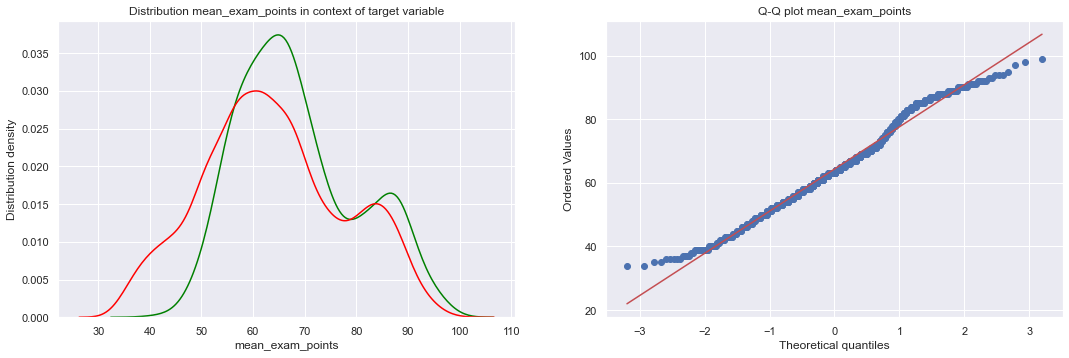

In [19]:
plot_kde_qq_interval(train, 'mean_exam_points')

In [20]:
shapiro_samples(train, 'mean_exam_points', 30, bxc = True)

Shapiro average P-value with reverse transformation: 5.863027021287456e-07
Shapiro average P-value without reverse transformation: 1.9639203540043153e-08
Threshold α = 0,05


In [21]:
manna_uitny(train, 'mean_exam_points', 30)

Mann–Whitney average P-value: 2.032700697771666e-11
Threshold α = 0,05


График наглядно демонстрирует разницу между репетиторами, о чем в дальнейшем свидетельствует критерий Манна-Уитни. Разница между двумя выборками очевидна.

Graph demonstrates the difference between tutors and the Mann-Whitney test confirms this.

### Сгенерируем новые признаки / Let's generate some new features

c:\python3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='qualification', ylabel='mean_exam_points'>

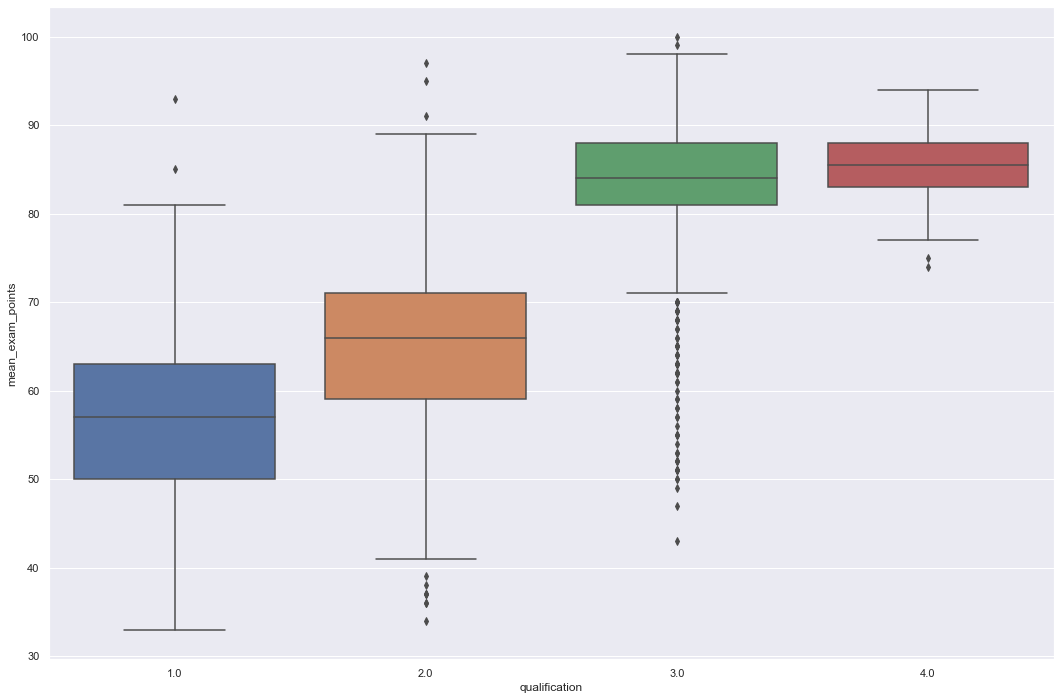

In [22]:
sns.boxplot(train['qualification'],train['mean_exam_points'])

Интересное наблюдение.У квалификаций (3,4) успеваемость выше, чем у (1,2). Создадим 4 группировки учеников в зависимости от квартилей. Так же выведем группы по *'age'* и *'price'*.

Qualifications (3,4) have higher academic performance than those (1,2).Let's create 4 groups of students depending on quartiles. Also make groups by *'age'* and *'price'*.

#### Train

In [23]:
train['age_group']=pd.cut(train['age'],[0,40,46,51,100],labels=[1,2,3,4]).astype('float')
train['price_group']=pd.cut(train['lesson_price'],[0,1300,1550,2150,10000],labels=[1,2,3,4]).astype('float')
train['qualification_height']=pd.cut(train['qualification'],[-1,3,5],labels=[0,1]).astype('float')

#### Test

In [24]:
test_df['age_group']=pd.cut(test_df['age'],[0,40,46,51,100],labels=[1,2,3,4]).astype('float')
test_df['price_group']=pd.cut(test_df['lesson_price'],[0,1300,1550,2150,10000],labels=[1,2,3,4]).astype('float')
test_df['qualification_height']=pd.cut(test_df['qualification'],[-1,3,5],labels=[0,1]).astype('float')

### Балансировка / Balancing

In [25]:
# Analogous to SMOTE balancing
def balance_df_by_target(df, target_name, balancing_type='oversampling'):
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()
    
    if balancing_type == 'oversampling':
        
        disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)

        return df.sample(frac=1) 
    
    if balancing_type == 'undersampling':
        
        major_class_sample = df[df[target_name] == major_class_name].sample(target_counts[minor_class_name])
        minor_class_sample = df[df[target_name] == minor_class_name]
        
        df = pd.concat([major_class_sample, minor_class_sample], ignore_index=True)
        
        return df.sample(frac=1) 

In [26]:
target = 'choose'
y = train[target]
X = train.drop(columns=['Id', 'choose'])
test_X = test_df.drop(columns='Id')

##### Ovarsampling

In [27]:
df_for_balancing = pd.concat([X, y], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, target, balancing_type='oversampling')
    
df_balanced[target].value_counts()

0    8891
1    8872
Name: choose, dtype: int64

##### Undersampling

In [28]:
"""df_for_balancing = pd.concat([X, y], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, target, balancing_type='undersampling')
    
df_balanced[target].value_counts()"""

"df_for_balancing = pd.concat([X, y], axis=1)\ndf_balanced = balance_df_by_target(df_for_balancing, target, balancing_type='undersampling')\n    \ndf_balanced[target].value_counts()"

In [29]:
X = df_balanced.drop(columns=target)
y = df_balanced[target]

### Стандартизируем признаки / Standardization

In [30]:
def Standard(data):
    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            data[i][j] = (data[i][j] - means[j])/stds[j]
    return data

In [31]:
X = X.values
y = y.values
test_X = test_X.values

In [32]:
Standard(X)
Standard(test_X)

array([[-1.72006918,  0.00807395,  1.90046712, ..., -2.78213675,
         1.4448819 , -0.07017213],
       [-1.35527949,  2.26652127,  0.19020064, ..., -1.66798964,
         0.53626544, -0.07017213],
       [-0.24663272,  0.00807395, -0.94997702, ...,  0.56030458,
        -1.28096749, -0.07017213],
       ...,
       [-0.24663272,  0.00807395, -0.85496222, ...,  0.56030458,
        -1.28096749, -0.07017213],
       [ 0.62846361,  1.70190944, -1.33003624, ...,  0.56030458,
        -1.28096749, -0.07017213],
       [-0.37078338, -1.12114971, -0.37988819, ...,  0.56030458,
        -0.37235103, -0.07017213]])

## Log_Loss model


In [33]:
class Logistic_regression:
    def __init__(self, n_iterations=1000, eta=0.05):
        self.n_iterations = 1000
        self.eta = eta

    @staticmethod
    def log_grad(w, c, X, target):
        m = X.shape[0]
        y = (2 * target - 1)
        score = np.dot(X, w.T).flatten()
        Z = -y / (m * (1 + np.exp(y * score)))
        grad = Z[np.newaxis, :].dot(X)
        return grad, np.sum(Z)

    @classmethod
    def optimize(cls, w, c, X, y, n_iterations, eta):
        for i in range(n_iterations):
            grad_w, grad_c = cls.log_grad(w, c, X, y)
            w = w - eta * grad_w
            c = c - eta * grad_c
        return w, c

    def fit(self, X, y):
        self.X = X
        self.y_true = y
        w0 = np.zeros((1, X.shape[1]))
        c0 = 0
        self.w, self.c = self.optimize(w0, c0, X, y, self.n_iterations, self.eta)

    def predict_proba(self, X):
        score = X.dot(self.w.T).flatten() + self.c
        self.score = score
        return 1 / (1 + np.exp(-score))

    def predict(self, X, thr=0.43): # Why threshold was set to this value? Below is a graph that explains this choice
        proba = self.predict_proba(X)
        y_predicted = np.zeros(proba.shape, dtype=bool)
        y_predicted[proba > thr] = 1
        y_predicted[proba <= thr] = 0
        self.y_predicted = y_predicted
        return y_predicted
    
    def confusion_matrix(self,X,y):
        y_pred = self.predict(X)
        predicted = np.where(y_pred == True, 1, 0)
        TP=np.sum(np.logical_and(predicted==1, y==1))
        FP=np.sum(np.logical_and(predicted==1, y==0))
        FN=np.sum(np.logical_and(predicted==0, y==1))
        TN=np.sum(np.logical_and(predicted==0, y==0))
        return np.array([[TP,FP],[FN, TN]])
         
        
    def make_auc_pr(self, X, Y):
        
        prob_x = self.predict_proba(X)
        targets = Y
        order = np.argsort(prob_x.flatten())
        targets = targets[order]
        num_pos=np.sum(targets)
        num_neg=len(targets)-num_pos

        TPR=np.concatenate([[0], np.cumsum(1-targets)/(num_neg)])
        FPR=np.concatenate([[0], np.cumsum(targets)/(num_pos)])
        
        plt.figure(figsize = (16, 7))
        plt.subplot(1,2,1)
        AUC_ROC = np.trapz(TPR, x = FPR, dx=0.1)
        plt.title('ROC curve')
        plt.ylim(0, 1.05)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.grid()
        plt.legend(' ', title=f'AUC-ROC={AUC_ROC:.3f}')
        plt.plot(FPR, TPR)
        plt.subplot(1,2,2)
        precision=np.cumsum(1-targets)/(np.cumsum(1-targets)+np.cumsum(targets))
        recall = TPR
        AUC_PR = np.sum(precision*(TPR[1:]-TPR[:-1]))
        plt.title('PR curve')
        plt.ylim(0, 1.05)
        plt.xlabel('recall')
        plt.ylabel('presision')
        plt.grid()
        plt.legend(' ', title=f'AUC-PR={AUC_PR:.3f}')
        plt.plot(recall[1:], precision)

### Log_Loss error

In [34]:
def log_loss(pred, y):
    return -np.sum(y*np.log(pred)+(1-y)*np.log(1-pred))/len(y)

### Classification report

In [35]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    """
    Outputs F1_score/precision/recall in accordance with model operation on training and test datasets + CONFUSION MATRIX
    """
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

### Train_test_split

In [36]:
def tts(X, y, test_size, random_state):
    np.random.seed(random_state)
    
    train_test_cut = int(len(X) * (1 - test_size))
    
    shuffle_index = np.random.permutation(X.shape[0])
    X_shuffled, y_shuffled = X[shuffle_index], y[shuffle_index]
    
    X_train, X_test, y_train, y_test = \
    X_shuffled[:train_test_cut], \
    X_shuffled[train_test_cut:], \
    y_shuffled[:train_test_cut], \
    y_shuffled[train_test_cut:]
    
    return X_train, X_test, y_train, y_test

In [37]:
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.3, random_state=21)

In [38]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12434, 14), (5329, 14), (12434,), (5329,))

In [39]:
model = Logistic_regression()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_test_pred_probs = model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.78      0.77      6229
           1       0.77      0.74      0.75      6205

    accuracy                           0.76     12434
   macro avg       0.76      0.76      0.76     12434
weighted avg       0.76      0.76      0.76     12434

TEST

              precision    recall  f1-score   support

           0       0.75      0.80      0.77      2662
           1       0.78      0.74      0.76      2667

    accuracy                           0.77      5329
   macro avg       0.77      0.77      0.77      5329
weighted avg       0.77      0.77      0.77      5329

CONFUSION MATRIX

col_0  False  True 
row_0              
0       2118    544
1        696   1971


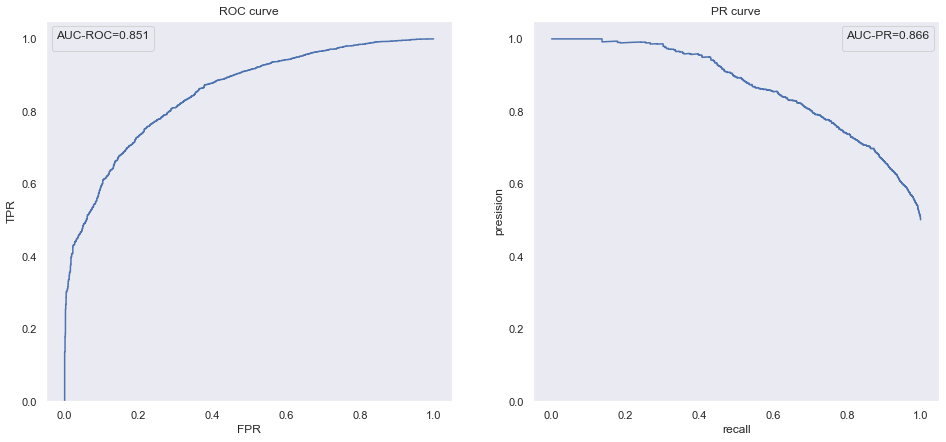

In [40]:
model.make_auc_pr(X_train, y_train)

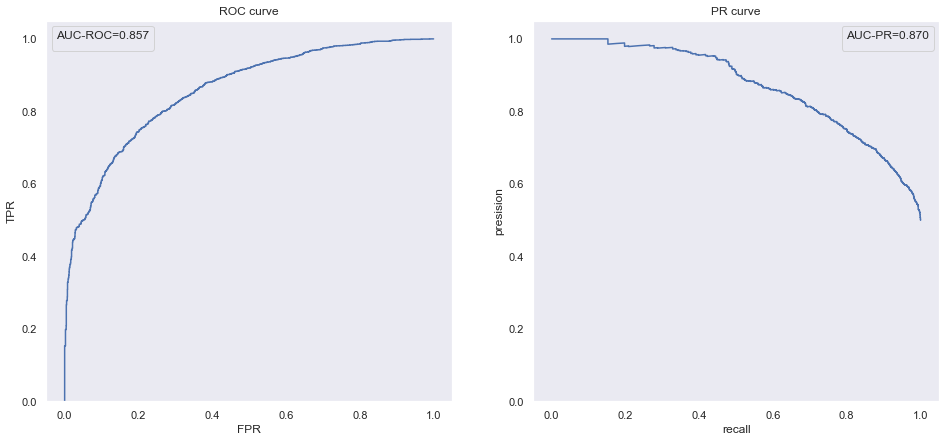

In [41]:
model.make_auc_pr(X_test, y_test)

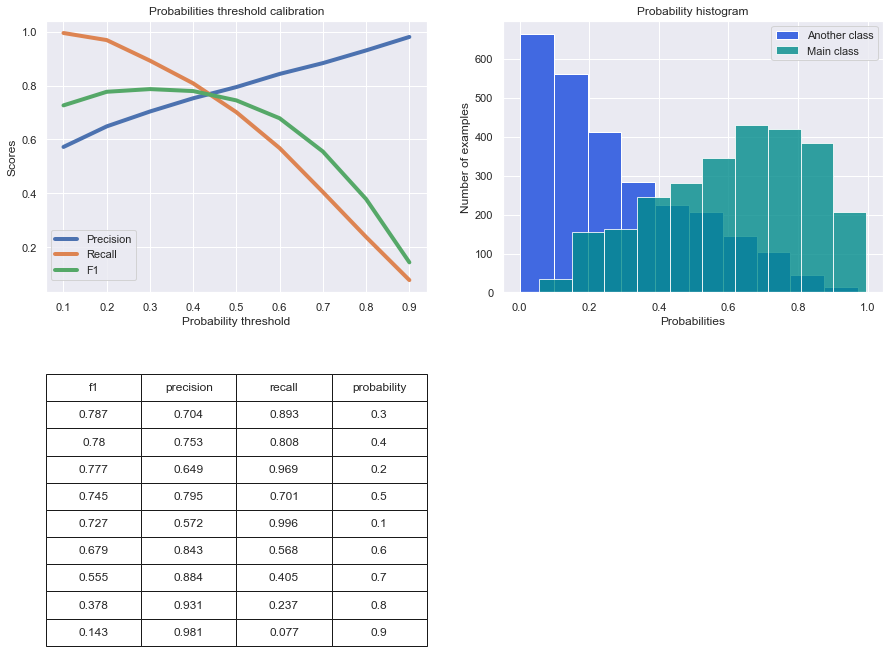

In [42]:
pred_proba = model.predict_proba(X_test)
show_proba_calibration_plots(pred_proba, y_test)

Let's train model on entire data set and predict probabilities(problem requires predicting probabilities, not class)

In [43]:
model.fit(X,y)

In [44]:
y_pred = model.predict_proba(test_X)

In [45]:
submis = pd.concat([test_df['Id'], pd.Series(y_pred)], axis = 1)
submis = submis.rename(columns = {0 : 'choose'})

In [46]:
submis.to_csv('LogLoss_predict.csv', index=None)